# **Image Processing for detecting Cracks in Mine Pillars**


### Group Members :



---------

### Import Used Libraries

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
# making a new directory with name kaggle
! mkdir ~/.kaggle
# /moving kaggle.json to root\kaggle
! cp kaggle.json ~/.kaggle/



In [ ]:
! kaggle competitions download -c 'arunrk7/surface-crack-detection'
! kaggle datasets download -d 'arunrk7/surface-crack-detection'


403 - Forbidden - Permission 'competitions.participate' was denied
100% 232M/233M [00:13<00:00, 21.7MB/s]
100% 233M/233M [00:13<00:00, 17.8MB/s]


In [ ]:
! unzip -q /content/surface-crack-detection.zip -d /content/surface-crack-detection


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import os
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, r2_score

import tensorflow as tf

### Get Positive & Negative Directories

In [ ]:
positive_dir = Path(r'/content/surface-crack-detection/Positive')
negative_dir = Path(r'/content/surface-crack-detection/Negative')

In [ ]:
for a,b,c in os.walk(r"/content/surface-crack-detection"):
  print(f"there are {len(b)} folders and {len(c)} files in {a}")

there are 2 folders and 0 files in /content/surface-crack-detection
there are 0 folders and 20000 files in /content/surface-crack-detection/Positive
there are 0 folders and 20000 files in /content/surface-crack-detection/Negative


### Creating DataFrames

In [ ]:
def generate_df(img_dir, label):

    file_paths = pd.Series(list(img_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=file_paths.index)
    df = pd.concat([file_paths, labels], axis=1)
    return df

In [ ]:
positive_df = generate_df(positive_dir, 'POSITIVE')
negative_df = generate_df(negative_dir, 'NEGATIVE')

all_df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1, random_state=1).reset_index(drop=True)
print(all_df)

                                                Filepath     Label
0      /content/surface-crack-detection/Positive/1279...  POSITIVE
1      /content/surface-crack-detection/Positive/0150...  POSITIVE
2      /content/surface-crack-detection/Positive/1774...  POSITIVE
3      /content/surface-crack-detection/Negative/0648...  NEGATIVE
4      /content/surface-crack-detection/Positive/1076...  POSITIVE
...                                                  ...       ...
39995  /content/surface-crack-detection/Positive/1397...  POSITIVE
39996  /content/surface-crack-detection/Negative/1142...  NEGATIVE
39997  /content/surface-crack-detection/Positive/1220...  POSITIVE
39998  /content/surface-crack-detection/Positive/0785...  POSITIVE
39999  /content/surface-crack-detection/Negative/0423...  NEGATIVE

[40000 rows x 2 columns]


### Split the DataSet

In [ ]:
train_df, test_df = train_test_split(all_df.sample(6000, random_state=1),
                train_size=0.7,
                shuffle=True,
                random_state=1)

### Loading Image Data

In [ ]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                           validation_split=0.2)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [ ]:
train_data = train_gen.flow_from_dataframe(train_df,
                                          x_col='Filepath',
                                          y_col='Label',
                                          target_size=(120,120),
                                          color_mode='rgb',
                                          class_mode='binary',
                                          batch_size=32,
                                          shuffle=True,
                                          seed=42,
                                          subset='training')


val_data = train_gen.flow_from_dataframe(train_df,
                                          x_col='Filepath',
                                          y_col='Label',
                                          target_size=(120,120),
                                          color_mode='rgb',
                                          class_mode='binary',
                                          batch_size=32,
                                          shuffle=True,
                                          seed=42,
                                          subset='validation')


test_data = test_gen.flow_from_dataframe(test_df,
                                          x_col='Filepath',
                                          y_col='Label',
                                          target_size=(120,120),
                                          color_mode='rgb',
                                          class_mode='binary',
                                          batch_size=32,
                                          shuffle=False,
                                          seed=42)

Found 3360 validated image filenames belonging to 2 classes.
Found 840 validated image filenames belonging to 2 classes.
Found 1800 validated image filenames belonging to 2 classes.


In [ ]:
test_data

### Model building

In [ ]:
inputs = tf.keras.Input(shape=(120,120,3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

In [ ]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [ ]:
# print model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 118, 118, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 59, 59, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 28, 28, 32)        0         
 g2D)                                                            
                                                                 
 global_average_pooling2d (  (None, 32)                0     

In [ ]:
history = model.fit(train_data, validation_data=val_data, epochs=100,
                   callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                              patience=30,
                                                              restore_best_weights=True)
                             ])

Epoch 1/100
105/105 [==============================] - 9s 39ms/step - loss: 0.6709 - accuracy: 0.6286 - val_loss: 0.6278 - val_accuracy: 0.6119
Epoch 2/100
105/105 [==============================] - 8s 81ms/step - loss: 0.5997 - accuracy: 0.7024 - val_loss: 0.5762 - val_accuracy: 0.6464
Epoch 3/100
105/105 [==============================] - 7s 71ms/step - loss: 0.5049 - accuracy: 0.8289 - val_loss: 0.4259 - val_accuracy: 0.9060
Epoch 4/100
105/105 [==============================] - 4s 36ms/step - loss: 0.4058 - accuracy: 0.9009 - val_loss: 0.3361 - val_accuracy: 0.9440
Epoch 5/100
105/105 [==============================] - 4s 42ms/step - loss: 0.3173 - accuracy: 0.9202 - val_loss: 0.2438 - val_accuracy: 0.9369
Epoch 6/100
105/105 [==============================] - 4s 40ms/step - loss: 0.2413 - accuracy: 0.9399 - val_loss: 0.1867 - val_accuracy: 0.9607
Epoch 7/100
105/105 [==============================] - 4s 36ms/step - loss: 0.2124 - accuracy: 0.9375 - val_loss: 0.1645 - val_accuracy:

### Plotting

In [ ]:
fig = px.line(history.history,
             y=['loss', 'val_loss'],
             labels={'index':'Epoch'},
             title='Training and Validation Loss over Time')

fig.show()

### Final Results

Test Loss 0.04674
Test Accuracy 98.89 %
57/57 [==============================] - 2s 27ms/step


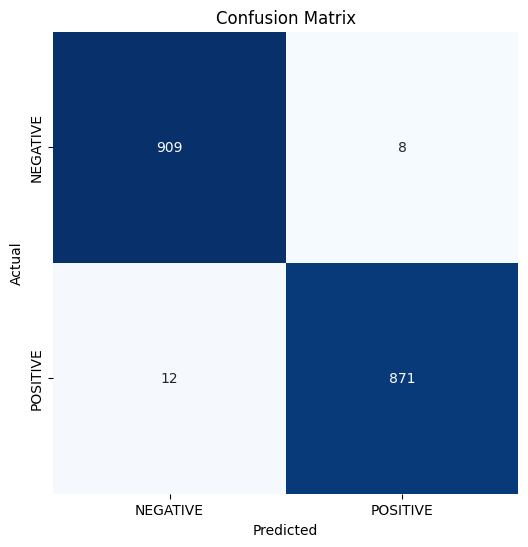

r2 Score :  0.955539692556974

Classification Report :
......................
               precision    recall  f1-score   support

    NEGATIVE       0.99      0.99      0.99       917
    POSITIVE       0.99      0.99      0.99       883

    accuracy                           0.99      1800
   macro avg       0.99      0.99      0.99      1800
weighted avg       0.99      0.99      0.99      1800



In [ ]:
results = model.evaluate(test_data, verbose=0)
loss = results[0]
accuracy = results[1]

print(f'Test Loss {loss:.5f}')
print(f'Test Accuracy {accuracy * 100:.2f} %')


# predicted y values
y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(int))
y_certain = np.squeeze((model.predict(test_data)).astype(int))

conf_matr = confusion_matrix(test_data.labels, y_pred)

class_report = classification_report(test_data.labels, y_pred,
                                         target_names=['NEGATIVE', 'POSITIVE'])

plt.figure(figsize=(6,6))

sns.heatmap(conf_matr, fmt='g', annot=True, cbar=False, vmin=0, cmap='Blues')

plt.xticks(ticks=np.arange(2) + 0.5, labels=['NEGATIVE', 'POSITIVE'])
plt.yticks(ticks=np.arange(2) + 0.5, labels=['NEGATIVE', 'POSITIVE'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print('r2 Score : ', r2_score(test_data.labels, y_pred))
print()
print('Classification Report :\n......................\n', class_report)

### Testing New DataSet

In [ ]:
def test_new_data(dir_path):

    new_test_dir = Path(dir_path)

    df_new = generate_df(new_test_dir, 'Testing')

    test_data_new = test_gen.flow_from_dataframe(df_new,
                                          x_col='Filepath',
                                          y_col='Label',
                                          target_size=(120,120),
                                          color_mode='rgb',
                                          batch_size=5,
                                          shuffle=False,
                                          seed=42)

    # predicted y values
    y_pred = np.squeeze((model.predict(test_data_new) >= 0.5).astype(int))


    y_certain = model.predict(test_data_new).round(6)
    y_out = []
    for i in y_pred:
        if i==0:
            y_out.append('Negative (Not Crack)')
        else:
            y_out.append('Positive(Crack) ')

    result = pd.DataFrame(np.c_[y_out, y_certain], columns=['Result', 'Confidance of being Cracked'])

    return result

In [ ]:
#results = test_new_data(r'/content/drive/MyDrive/200_Check')

In [ ]:
import matplotlib.pyplot as plt
import random
import cv2
import numpy as np

[[0.45649725]] [0.45649725] 0.45649725
y_true Negative y_predict negative


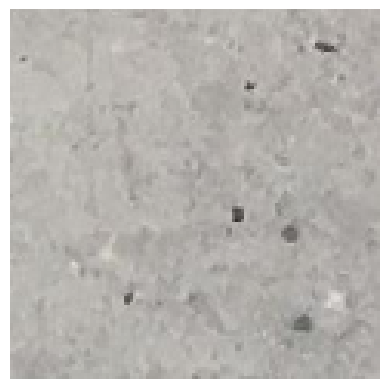

In [ ]:
def func(path,model):
  y_true=random.choice(os.listdir(path))
  folder_path=os.path.join(path,y_true)
  file_path=os.path.join(folder_path,random.choice(os.listdir(folder_path)))
  img=cv2.imread(file_path)
  img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img=cv2.resize(img,(120,120))
  img_scalled=img.astype("float32")
  img_scalled=img_scalled/255.
  img_scalled=np.expand_dims(img_scalled,axis=0)
  predicted=model.predict(img_scalled,verbose=0)
  print(predicted[0][0])
  if predicted[0][0]<0.5:
    y_pred="negative"
  else:
    y_pred="positive"
  print("actual: ",y_true,"predicted: ",y_pred)
  plt.imshow(img)
  plt.axis("off")
  plt.show
func("/content/surface-crack-detection",model)

AttributeError: 'list' object has no attribute 'to_csv'